In [4]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mean_squared_error
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.models import Sequential
import gc
from sklearn.linear_model import LinearRegression

from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

In [497]:
agg_data1 = pd.read_csv("aggday.csv")


In [524]:
set(agg_data1[agg_data1['kwh']>50]['Source'])

{'consumer_device_13_data_user_10',
 'consumer_device_13_data_user_4',
 'consumer_device_13_data_user_5',
 'consumer_device_13_data_user_6',
 'consumer_device_13_data_user_7',
 'consumer_device_13_data_user_8',
 'consumer_device_18_data_user_10',
 'consumer_device_18_data_user_11',
 'consumer_device_18_data_user_12',
 'consumer_device_18_data_user_4',
 'consumer_device_18_data_user_5',
 'consumer_device_18_data_user_6',
 'consumer_device_18_data_user_7',
 'consumer_device_18_data_user_8',
 'consumer_device_18_data_user_9',
 'consumer_device_19_data_user_3',
 'consumer_device_21_data_user_3',
 'consumer_device_2_data_user_1',
 'consumer_device_32_data_user_19',
 'consumer_device_32_data_user_4',
 'consumer_device_7_data_user_2',
 'consumer_device_7_data_user_3',
 'consumer_device_7_data_user_4',
 'consumer_device_7_data_user_5'}

,Source,hour,kwh
0,consumer_device_10_data_user_1,2024-07-22 18:00:00,0.005017
1,consumer_device_10_data_user_1,2024-07-22 19:00:00,0.003731
2,consumer_device_10_data_user_1,2024-07-22 20:00:00,0.001748
3,consumer_device_10_data_user_1,2024-07-22 21:00:00,0.006342
4,consumer_device_10_data_user_1,2024-07-22 22:00:00,0.003937
...,...,...,...
3262647,consumer_device_9_data_user_9,2024-09-14 01:00:00,0.000000
3262648,consumer_device_9_data_user_9,2024-09-14 02:00:00,0.000000
3262649,consumer_device_9_data_user_9,2024-09-14 03:00:00,0.000000
3262650,consumer_device_9_data_user_9,2024-09-14 04:00:00,0.000000


In [5]:
aggregated_data = pd.read_csv("Data/Data.csv")


In [525]:
source_name = 'consumer_device_21_data_user_3' # Remplacer par le nom de la source


In [526]:
df= aggregated_data [aggregated_data ['Source']==source_name]

In [527]:
# Convertir 'date_time' en datetime si ce n'est pas déjà fait
df['date_time'] = pd.to_datetime(df['date_time'])

# Extraire l'heure de la colonne 'date_time'
df['hour'] = df['date_time'].dt.floor('H')  # Arrondir à l'heure la plus proche

# Agréger les données par 'consumer_device', 'data_user' et 'hour' (au lieu de 'Date')
agg_data = df.groupby([ 'hour'])[['kwh']].sum().reset_index()


In [528]:
complete_data=agg_data.copy()

In [529]:
complete_data

,hour,kwh
0,2024-07-06 10:00:00,0.000652
1,2024-07-06 11:00:00,0.000000
2,2024-07-06 12:00:00,0.000000
3,2024-07-06 13:00:00,0.000000
4,2024-07-06 14:00:00,0.000000
...,...,...
1905,2024-09-23 19:00:00,2.434326
1906,2024-09-23 20:00:00,2.202056
1907,2024-09-23 21:00:00,2.802321
1908,2024-09-23 22:00:00,2.815616


In [530]:
complete_data.rename(columns={'hour': 'Date'}, inplace=True)


In [531]:
def climatiseur(complete_data):
    climate_df = pd.read_excel("Climate Data/Kalam Climate Data.xlsx")  # Convert to datetime
    complete_data["Date"] = pd.to_datetime(complete_data["Date"])
    climate_df["Date Time"] = pd.to_datetime(climate_df["Date Time"])

    # Aggregate climate data to hourly level
    climate_hourly = climate_df.groupby(climate_df["Date Time"].dt.floor('H')).agg({
        "Temperature (°C)": "mean",
        "Dewpoint Temperature (°C)": "mean",
        "U Wind Component (m/s)": "mean",
        "V Wind Component (m/s)": "mean",
        "Total Precipitation (mm)": "sum",
        "Snowfall (mm)": "sum",
        "Snow Cover (%)": "mean",
    }).reset_index()

    # Convert 'Date' column in climate_hourly to datetime format
    climate_hourly.rename(columns={"Date Time": "Date"}, inplace=True)
    climate_hourly["Date"] = pd.to_datetime(climate_hourly["Date"])  # Ensure datetime64[ns]

    # Merge with complete_data
    complete_data["Date"] = complete_data["Date"].dt.floor('H')  # Ensure hourly format for merge
    complete_data = complete_data.merge(climate_hourly, on="Date", how="left")
    
    return complete_data


In [532]:
def pro2(complete_data):

    # Assurer que 'Date' est bien en format datetime
    complete_data['Date'] = pd.to_datetime(complete_data['Date'])

    # Extraire jour, mois et année
    complete_data['day'] = complete_data['Date'].dt.day
    complete_data['month'] = complete_data['Date'].dt.month
    complete_data['year'] = complete_data['Date'].dt.year

    # Transformation circulaire pour les jours du mois (1 à 31)
    complete_data['day_sin'] = np.sin(2 * np.pi * complete_data['day'] / 31)
    complete_data['day_cos'] = np.cos(2 * np.pi * complete_data['day'] / 31)

    # Transformation circulaire pour les mois (1 à 12)
    complete_data['month_sin'] = np.sin(2 * np.pi * complete_data['month'] / 12)
    complete_data['month_cos'] = np.cos(2 * np.pi * complete_data['month'] / 12)

    # Transformation circulaire pour les années (en fonction de l'année minimale présente)
    year_min = complete_data['year'].min()
    complete_data['year_sin'] = np.sin(2 * np.pi * (complete_data['year'] - year_min) / (complete_data['year'].max() - year_min + 1))
    complete_data['year_cos'] = np.cos(2 * np.pi * (complete_data['year'] - year_min) / (complete_data['year'].max() - year_min + 1))

    # Déterminer si c'est un week-end (samedi = 5, dimanche = 6)
    complete_data['is_weekend'] = complete_data['Date'].dt.weekday >= 5
    #complete_data = complete_data.merge(df_voltage, on='Source', how='left')
    #complete_data =complete_data.merge(df_type_voltage, on='Source', how='left')

    return complete_data


In [533]:
complete_data=climatiseur(complete_data)


In [534]:
complete_data=pro2(complete_data)


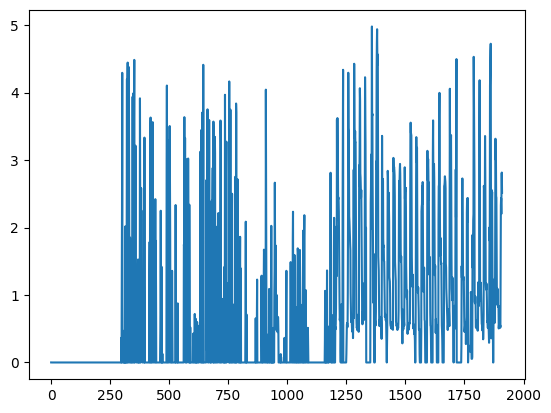

In [538]:
plt.plot(complete_data['kwh'])

In [539]:
complete_data.shape

(1910, 19)

In [540]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Charger les données (assumons que complete_data est déjà chargé)
df = complete_data.copy()

# Convertir la colonne Date en datetime
df['Date'] = pd.to_datetime(df['Date'])

# Supprimer les colonnes non pertinentes pour la prédiction
df = df.drop(columns=['Date', 'day', 'month', 'year', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'year_sin', 'year_cos'])

# Imputer les valeurs manquantes si nécessaire (ici, on remplace par 0 pour l'exemple)
df = df.fillna(0)

# Normalisation des données
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Séparer les 90 % des données pour l'entraînement et 10 % pour le test
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Créer des séquences temporelles
def create_sequences(data, time_step=24):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step])
        y.append(data[i+time_step, 0])  # kwh est la première colonne
    return np.array(X), np.array(y)

# Créer des séquences pour les ensembles d'entraînement et de test
time_step = 24*4
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Reshaping des données pour l'LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))


In [541]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Définir l'architecture du modèle LSTM
model = Sequential()
model.add(LSTM(units=60, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(32))
model.add(Dense(units=1))  # Unité de sortie pour prédire 'kwh'

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Résumé du modèle
model.summary()

# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=20, batch_size=50, validation_data=(X_test, y_test))


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 60)                16800     
                                                                 
 dense_43 (Dense)            (None, 32)                1952      
                                                                 
 dense_44 (Dense)            (None, 1)                 33        
                                                                 
Total params: 18,785
Trainable params: 18,785
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
29/29 [==============================] - 6s 88ms/step - loss: 0.0498 - val_loss: 0.0464
Epoch 2/20
29/29 [==============================] - 2s 77ms/step - loss: 0.0330 - val_loss: 0.0409
Epoch 3/20
29/29 [==============================] - 2s 68ms/step - loss: 0.0307 - val_loss: 0.0383
Epoch 4/20
29/29

In [542]:
predictions = model.predict(X_test)

9/9 [==============================] - 1s 20ms/step


In [543]:
testing = scaler.inverse_transform(test_data)


In [544]:
realtest=np.array(pd.DataFrame(testing)[0] [time_step:])

In [545]:
rmse = np.sqrt(np.mean((realtest- predictions) ** 2))
rmse

1.4601859815199845

In [546]:
len(testing )/24

15.916666666666666

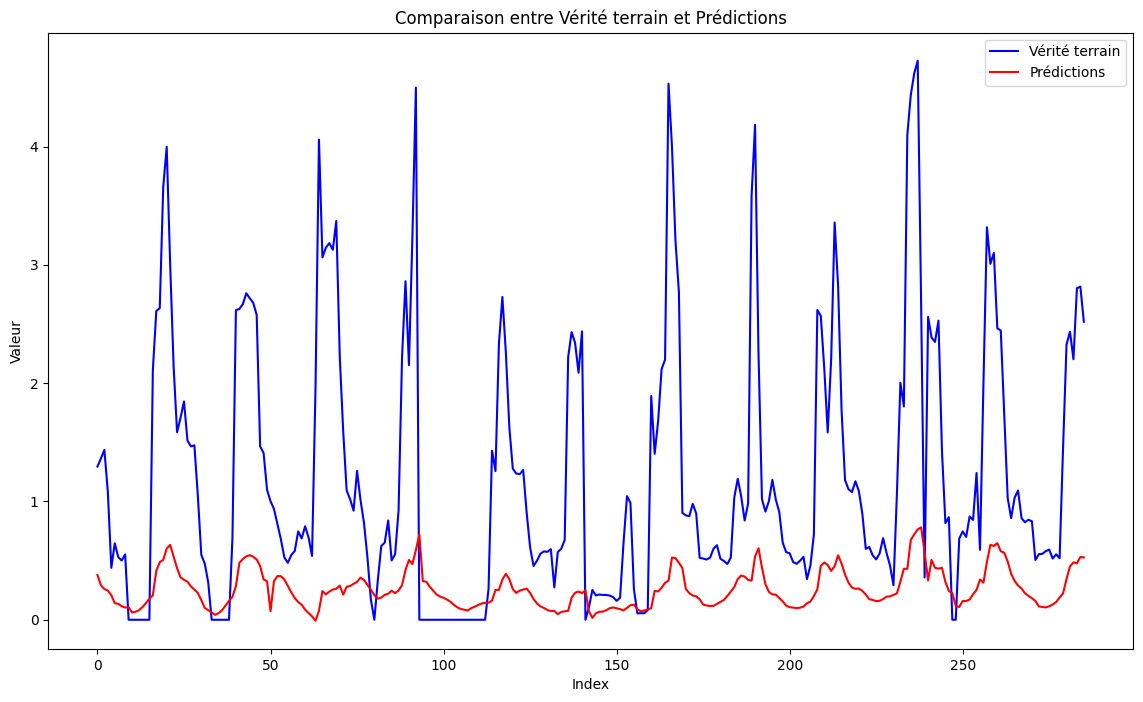

In [547]:
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(figsize=(14, 8))

# Tracer les deux séries de données
plt.plot(realtest, label="Vérité terrain", color='blue')  # Tracer la série testing
plt.plot(predictions, label="Prédictions", color='red')  # Tracer la série predictions

# Ajouter des titres et des légendes
plt.title("Comparaison entre Vérité terrain et Prédictions")
plt.xlabel("Index")
plt.ylabel("Valeur")
plt.legend()  # Afficher la légende

# Afficher le graphique
plt.show()
